In [1]:
#pip install xgboost

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics


In [3]:
df=pd.read_csv("高雄市房價.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62174 entries, 0 to 62173
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   經度      62174 non-null  float64
 1   緯度      62174 non-null  float64
 2   屋齡      51899 non-null  float64
 3   面積      62174 non-null  object 
 4   建物類型    62174 non-null  object 
 5   用途      53045 non-null  object 
 6   樓別/樓高   62111 non-null  object 
 7   佈局      58298 non-null  object 
 8   電梯      56742 non-null  object 
 9   管理員     62174 non-null  object 
 10  車位數量    62174 non-null  int64  
 11  價格      62174 non-null  object 
 12  行政區     62174 non-null  object 
 13  交易年份    62174 non-null  int64  
dtypes: float64(3), int64(2), object(9)
memory usage: 6.6+ MB


In [5]:
#
df["經度"]=df["經度"].replace(".","",regex=True).astype("float")
df["價格"]=df["價格"].replace(",","",regex=True).astype("float")
df["面積"]=df["面積"].replace(",","",regex=True).astype("float")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62174 entries, 0 to 62173
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   經度      62174 non-null  float64
 1   緯度      62174 non-null  float64
 2   屋齡      51899 non-null  float64
 3   面積      62174 non-null  float64
 4   建物類型    62174 non-null  object 
 5   用途      53045 non-null  object 
 6   樓別/樓高   62111 non-null  object 
 7   佈局      58298 non-null  object 
 8   電梯      56742 non-null  object 
 9   管理員     62174 non-null  object 
 10  車位數量    62174 non-null  int64  
 11  價格      62174 non-null  float64
 12  行政區     62174 non-null  object 
 13  交易年份    62174 non-null  int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 6.6+ MB


In [6]:

df.isnull().sum()/len(df)

經度       0.000000
緯度       0.000000
屋齡       0.165262
面積       0.000000
建物類型     0.000000
用途       0.146830
樓別/樓高    0.001013
佈局       0.062341
電梯       0.087368
管理員      0.000000
車位數量     0.000000
價格       0.000000
行政區      0.000000
交易年份     0.000000
dtype: float64

In [7]:
len(df)

62174

In [8]:
#處理缺失值
#基本上我們把佈局的缺失值刪掉，因為不知怎麼填
df.dropna(subset=["佈局"],inplace=True)
#屋齡我們用fillna平均值
average_age = df["屋齡"].mean()
df["屋齡"].fillna(average_age,inplace=True)
#用途我們用眾數
df["用途"].value_counts()
df["用途"].fillna("住家用",inplace=True)
#樓別樓高刪除
df.dropna(subset=["樓別/樓高"],inplace=True)
#電梯我們用無來代替
df["電梯"].fillna("無",inplace=True)


In [9]:
df.isnull().sum()/len(df)

經度       0.0
緯度       0.0
屋齡       0.0
面積       0.0
建物類型     0.0
用途       0.0
樓別/樓高    0.0
佈局       0.0
電梯       0.0
管理員      0.0
車位數量     0.0
價格       0.0
行政區      0.0
交易年份     0.0
dtype: float64

In [10]:
df.describe()

,經度,緯度,屋齡,面積,車位數量,價格,交易年份
count,58240.000000,58240.000000,58240.000000,58240.000000,58240.000000,5.824000e+04,58240.000000
mean,120.280555,22.638166,25.109389,42.909840,0.528177,1.056444e+07,110.300172
std,1.865181,0.351865,14.224886,39.207609,0.681438,1.796583e+07,1.088444
min,0.000000,0.000000,1.000000,0.000000,0.000000,2.200000e+04,109.000000
25%,120.296706,22.627291,15.000000,25.650000,0.000000,5.000000e+06,109.000000
50%,120.309568,22.643350,25.109389,36.970000,0.000000,8.000000e+06,110.000000
75%,120.321527,22.663116,36.000000,51.210000,1.000000,1.260000e+07,111.000000
max,120.349746,22.709359,102.000000,5149.790000,43.000000,2.700000e+09,113.000000


In [11]:
#處理OUTLIER
df.describe()
#我們處理的主要是面積 車位 價格 
for outlier in ["面積","車位數量","價格"]:
    stat = df[outlier].describe()
    IQR = stat["75%"] - stat["25%"]
    upper_limit = stat["75%"] + 1.5 * IQR
    df = df[df[outlier] <= upper_limit]
    

In [12]:
df.describe()

,經度,緯度,屋齡,面積,車位數量,價格,交易年份
count,52611.000000,52611.000000,52611.000000,52611.000000,52611.000000,5.261100e+04,52611.000000
mean,120.296469,22.640765,26.012331,36.491047,0.455893,8.164533e+06,110.295204
std,1.284852,0.243024,13.868322,15.858399,0.536457,4.621251e+06,1.091327
min,0.000000,0.000000,1.000000,0.000000,0.000000,2.200000e+04,109.000000
25%,120.297155,22.626495,17.000000,24.730000,0.000000,4.700000e+06,109.000000
50%,120.310801,22.642807,25.109389,34.540000,0.000000,7.350000e+06,110.000000
75%,120.322329,22.663116,37.000000,46.595000,1.000000,1.100000e+07,111.000000
max,120.349746,22.709359,102.000000,89.550000,2.000000,2.180000e+07,113.000000


資料缺失值，極端值都處理完了，我們要做feature engineering 之前 還是要先做一下資料簡化以及EDA

In [13]:
#先把資料簡化，我這樣比較好做
#先處理建物類型
df["建物類型"].unique()
df["建物類型"]=df["建物類型"].str.split("(",expand=True)[0]

In [14]:
df["建物類型"].unique()
df.loc[df["建物類型"].isin(["廠辦","辦公商業大樓"]),"建物類型"]="其他"


In [15]:

df.loc[df["建物類型"].isin(["店面（店舖)"]),"建物類型"]="店面"

In [16]:
df["建物類型"].unique()

array(['透天厝', '公寓', '華廈', '住宅大樓', '套房', '店面', '其他'], dtype=object)

In [17]:
#接下來處理用途
df["用途"].unique()
df.loc[~df['用途'].isin(['住家用','住商用','商業用','辦公用','其他']), '用途'] = '其他'

In [18]:
df["用途"].unique()

array(['住家用', '住商用', '商業用', '其他', '辦公用'], dtype=object)

In [19]:
#處理樓高/樓別 非常麻煩
df["樓別"]=df["樓別/樓高"].str.split("/",expand=True)[0]
df["樓高"]=df["樓別/樓高"].str.split("/",expand=True)[1]
df.drop("樓別/樓高",axis=1,inplace=True)

In [20]:
df["樓別"].value_counts()

全                        6326
四層                       4813
五層                       4640
三層                       4314
二層                       2947
                         ... 
一層,二層,三層,屋頂突出物,騎樓,地下層       1
二層,通道                       1
一層,騎樓,電梯樓梯間                 1
十七層,走廊                      1
十一層,十二層,十三層                 1
Name: 樓別, Length: 216, dtype: int64

In [21]:
df["樓別"]=df["樓別"].str.split(",",expand=True)[0]

In [22]:
len(df["樓別"].unique())

42

In [23]:
def categoryfloor(floor):
    if floor in ["地下二層",'地下一層']:
        return "地下"
    elif floor in "全":
        return "全層"
    elif floor in ["一層","二層","三層","四層","五層"]:
        return "低樓層"
    elif floor in ["六層","七層","八層","九層","十層","十一層","十二層","十三層","十四層","十五層"]:
        return "中樓層"
    else:
        return "高樓層"
    

In [24]:
df["樓別"]=df["樓別"].apply(categoryfloor)

In [25]:
#處理樓高
df["樓高"].value_counts()
df.loc[df["樓高"].isin(["(空白)"]),"樓高"]="十二層"
df["樓高"].unique()

array(['二層', '五層', '九層', '十層', '十五層', '十二層', '十六層', '十三層', '四層', '十九層',
       '二十一層', '十七層', '七層', '八層', '十四層', '十八層', '二十二層', '二十四層', '十一層',
       '三層', '二十層', '二十五層', '二十八層', '六層', '二十六層', '二十九層', '二十三層', '二十七層',
       '--', '一層', '三十層', '三十五層', '八十五層', '三十三層', '四十一層', '三十七層', '三十九層'],
      dtype=object)

In [26]:
df["樓高"]=df["樓高"].apply(categoryfloor)

In [27]:
#接下來處理佈局
df["房"]=df["佈局"].str.split("房",expand=True)[0]
df["房"].unique()




array(['2', '5', '3', '1', '4', '7', '2廳1衛', '6', '2衛', '2廳2衛', '8', '10',
       '97', '9', '1廳1衛', '13', '12', '1衛', '5廳3衛', '3廳3衛', '3衛', '14',
       '11', '1廳3衛', '4廳2衛', '17', '15', '1廳2衛', '1廳', '18', '3廳2衛', '2廳',
       '4廳4衛', '3廳', '42', '5廳4衛', '5廳2衛', '2廳4衛', '33', '4衛', '4廳3衛',
       '3廳1衛'], dtype=object)

In [28]:
df["房"]=df["房"].apply(lambda x: '0' if '廳' in x or '衛' in x else x)
    

In [29]:
df["房"].unique()

array(['2', '5', '3', '1', '4', '7', '0', '6', '8', '10', '97', '9', '13',
       '12', '14', '11', '17', '15', '18', '42', '33'], dtype=object)

In [30]:

df["廳"]=df["佈局"].str.split("房",expand=True)[1].str.split("廳",expand=True)[0]


In [31]:
data=df["廳"]

In [32]:
data[data == None] = '0'
data[data == ''] = '0'
df["廳"]=data
df["廳"] = df["廳"].apply(lambda x: '0' if x is None or '衛' in str(x) else x)


                                     
    

In [33]:
df["衛"]=df["佈局"].str.split("房",expand=True)[1].str.split("廳",expand=True)[1].str.split("衛",expand=True)[0]
df["衛"].unique()
df["衛"].unique()
data=df["衛"]
data[data == ''] = '0'
df["衛"]=data
df["衛"] = df["衛"].apply(lambda x: '0' if x is None or '衛' in str(x) else x)






In [34]:
df.drop("佈局",axis=1,inplace=True)

In [35]:
for i in ["房","廳","衛"]:
    df[i]=df[i].astype(float)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52611 entries, 0 to 62171
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   經度      52611 non-null  float64
 1   緯度      52611 non-null  float64
 2   屋齡      52611 non-null  float64
 3   面積      52611 non-null  float64
 4   建物類型    52611 non-null  object 
 5   用途      52611 non-null  object 
 6   電梯      52611 non-null  object 
 7   管理員     52611 non-null  object 
 8   車位數量    52611 non-null  int64  
 9   價格      52611 non-null  float64
 10  行政區     52611 non-null  object 
 11  交易年份    52611 non-null  int64  
 12  樓別      52611 non-null  object 
 13  樓高      52611 non-null  object 
 14  房       52611 non-null  float64
 15  廳       52611 non-null  float64
 16  衛       52611 non-null  float64
dtypes: float64(8), int64(2), object(7)
memory usage: 7.2+ MB


In [37]:
df["價格"]=df["價格"]/10000
df.to_csv("K_Town_clean_data")

資料基本清理完畢，我們做一下EDA

<Axes: xlabel='價格', ylabel='Count'>

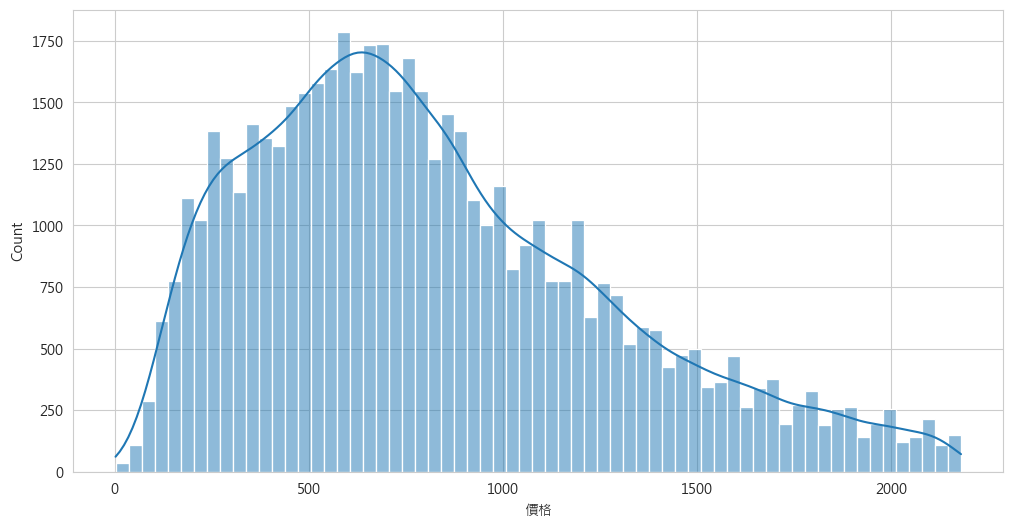

In [38]:
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(12,6))
sns.histplot(x="價格",data=df,kde=True)

<Axes: xlabel='價格', ylabel='Density'>

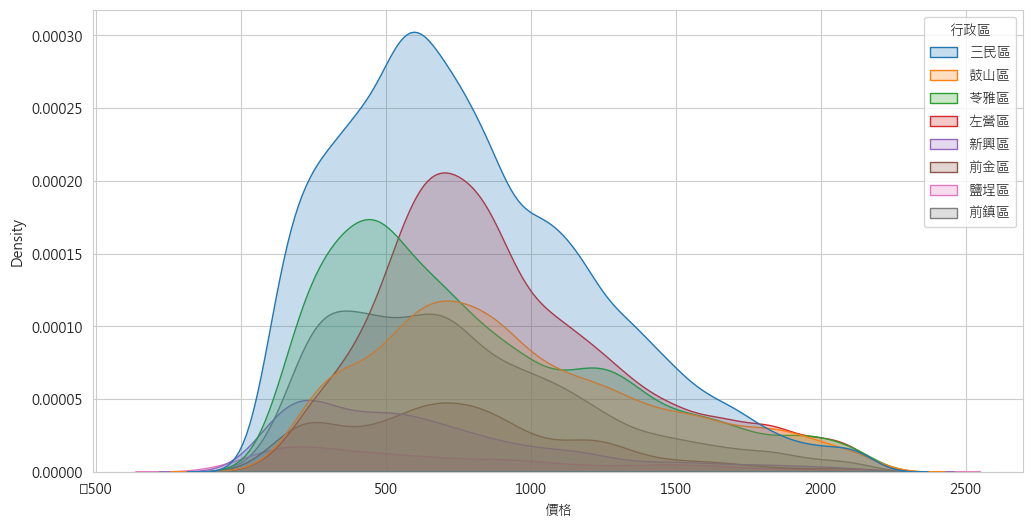

In [39]:
#三民 左營
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.figure(figsize=(12,6))
sns.kdeplot(x="價格",data=df,shade=True,hue="行政區")

<Axes: xlabel='行政區', ylabel='價格'>

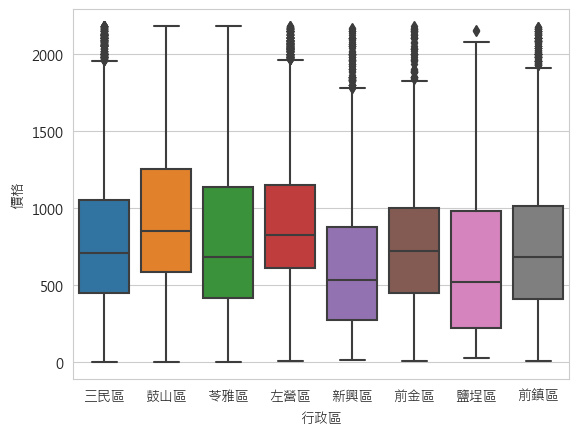

In [40]:
#鼓山意外的貴，美術館?
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
sns.boxplot(x="行政區",y="價格",data=df)

<Axes: >

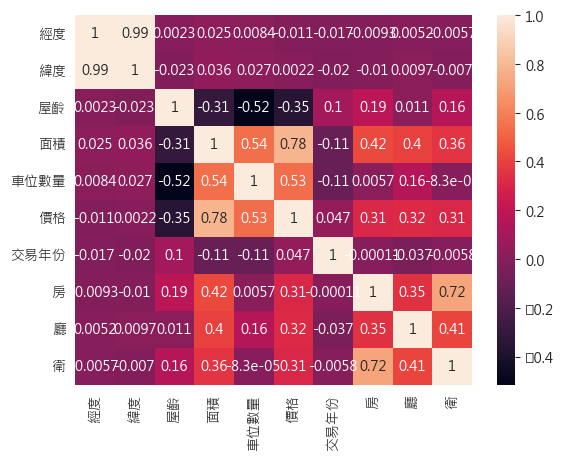

In [41]:
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
sns.heatmap(df.corr(),annot=True)

In [42]:
df1=pd.get_dummies(df,columns=["建物類型","行政區","用途","管理員","電梯","樓別","樓高"],drop_first=True)

In [43]:
df1.head()

,經度,緯度,屋齡,面積,車位數量,價格,交易年份,房,廳,衛,...,用途_商業用,用途_辦公用,管理員_無,電梯_無,樓別_低樓層,樓別_全層,樓別_地下,樓別_高樓層,樓高_低樓層,樓高_高樓層
0,120.315425,22.636614,60.0,14.30,0,430.0,113,2.0,1.0,2.0,...,0,0,1,1,0,1,0,0,1,0
1,120.318331,22.662842,40.0,24.76,0,280.0,113,5.0,2.0,2.0,...,0,0,1,1,1,0,0,0,1,0
2,120.306232,22.640349,30.0,36.70,0,620.0,112,3.0,2.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,120.324755,22.648501,54.0,30.42,0,1000.0,112,3.0,2.0,2.0,...,0,0,1,1,0,1,0,0,1,0
4,120.319218,22.650555,17.0,4.88,0,134.5,112,1.0,1.0,1.0,...,1,0,0,1,0,0,0,0,0,0


In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52611 entries, 0 to 62171
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   經度        52611 non-null  float64
 1   緯度        52611 non-null  float64
 2   屋齡        52611 non-null  float64
 3   面積        52611 non-null  float64
 4   車位數量      52611 non-null  int64  
 5   價格        52611 non-null  float64
 6   交易年份      52611 non-null  int64  
 7   房         52611 non-null  float64
 8   廳         52611 non-null  float64
 9   衛         52611 non-null  float64
 10  建物類型_公寓   52611 non-null  uint8  
 11  建物類型_其他   52611 non-null  uint8  
 12  建物類型_套房   52611 non-null  uint8  
 13  建物類型_店面   52611 non-null  uint8  
 14  建物類型_華廈   52611 non-null  uint8  
 15  建物類型_透天厝  52611 non-null  uint8  
 16  行政區_前金區   52611 non-null  uint8  
 17  行政區_前鎮區   52611 non-null  uint8  
 18  行政區_左營區   52611 non-null  uint8  
 19  行政區_新興區   52611 non-null  uint8  
 20  行政區_苓雅區   52611 non-null  ui

In [45]:
X= df1.drop(["價格"],axis =1)
y= df1["價格"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=101)

In [46]:
pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("kn_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("xgb_classifier",XGBRegressor())])


pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]


pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}
#fit model
for pipe in pipelines:
    pipe.fit(X_train, y_train)



In [47]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -240.671639 
DecisionTree: -235.465129 
RandomForest: -170.964651 
KNeighbors: -222.632516 
XGBRegressor: -167.668795 


In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
#根據評分 我們打算使用XGBTegressor
XGB_model=XGBRegressor()

In [50]:
#根據評分我們選用XGBRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


XGB_model = XGBRegressor()


param_grid = {"max_depth": [2, 4, 6, 8, 10],
              "min_child_weight": [4, 5, 6]}


grid = GridSearchCV(estimator=XGB_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)


best_params = grid.best_params_

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 8, 'min_child_weight': 6}


In [51]:
pred=grid.predict(X_test)


In [52]:
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
adj_r=1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

R^2: 0.8673343475413736
Adjusted R^2: 0.8669904969403983
MAE: 104.24274880910309
MSE: 28246.9737732046
RMSE: 168.0683604168393


Text(0.5, 1.0, 'adj-R_squared 為0.8669904969403983')

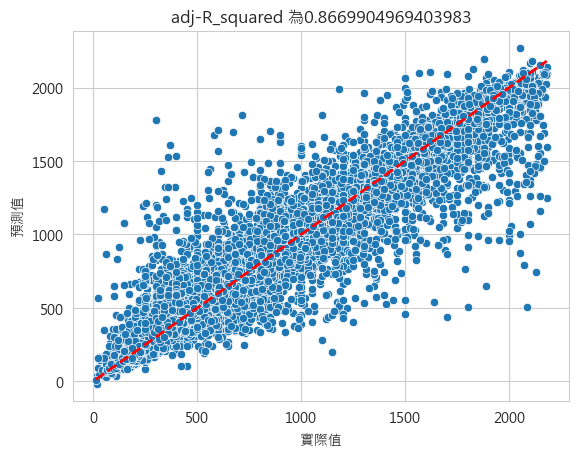

In [53]:
sns.scatterplot(x=y_test,y=pred)
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title(f"adj-R_squared 為{adj_r}")